In [1]:
from neuralOCR import character_extraction 
from matplotlib import pyplot as plt
import importlib
import cv2
import numpy as np
import os
import glob
import re
from copy import deepcopy
import pandas as pd
import scipy.stats as stats
import math

# Convert multi page pdfs into individual pngs

In [2]:
directory = "/home/ggdhines/bear/"

In [ ]:
def run(cmd):
    r = os.system(cmd)
    if r != 0:
        print(r)
        assert False


for page in range(5,75,2):
    print(page,end="\r")
    output_file = f"{directory}{ship}-{year}-{month}-{page}"

    if os.path.isfile(f"{output_file}-1.png"):
        continue
        
    cmd = f"pdftk {directory}{ship}-{year}-{month}.pdf cat {page} output temp.pdf"
    run(cmd)
    
    
    cmd = f"pdftoppm -png temp.pdf {output_file}"
    run(cmd)

# Image Alignment

In [ ]:
for page in range(7,75,2):
    base_fn = f"{directory}{ship}-{year}-{month}-{page}" 
    file = f"{base_fn}-1.png"
    print(page,end="\r")
    if not os.path.isfile(file):
        continue
        
    img = cv2.imread(file,0)
    img_ = cv2.resize(img, (0, 0), fx=scale, fy=scale)

    aligned_image = character_extraction.align_images(img_,img_half,img,scale=scale)
    cv2.imwrite(f"{base_fn}-aligned.png",aligned_image)

# Template Extraction

In [3]:
height = 11696
width = 7801

In [4]:
template = np.zeros((height,width)).astype(np.float)
for fname in os.listdir(directory):
    match = re.search("(.*)-(\d+)-(\d+)\-(\d*)-aligned.png",fname)
    if match is None:
        continue

    print(fname,end="\r")

    ship,year,month,page = match.groups()

    image = cv2.imread(directory+fname,0)
#     binary_image = character_extraction.gauss_threshold(image)
    
    template += image
    
template = template/31

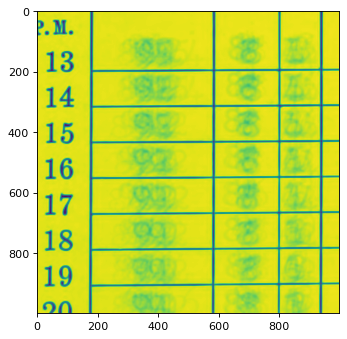

In [5]:
fig = plt.figure(num=None, figsize=(5, 5), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.imshow(template[7400:8400,1000:2000])
plt.show()

Template pixels are going to be dark in every image. Since the text and text position changes from page to page, a pixel may be part of the log entry in page and not in an other (i.e. just a paper pixel). Even if a pixel is sometimes part of the log entry, its average darkness will be brighter than template pixels. We can use the following histrogram to help decide on a threshold.

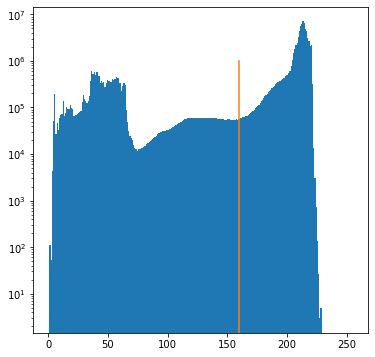

In [6]:
fig = plt.figure(num=None, figsize=(6, 6), facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
_ = ax.hist(template.ravel(),bins=range(0,256,1))
ax.set_yscale('log')
ax.plot([160,160],[0,1000000])
plt.show()

There isn't a perfect threshold, but 160 (the orange line) seems like a good choice and the images below confirm that. 170 also produced good results (at least for the part of the template shown below), so we can probably adjust the threshold if need be.

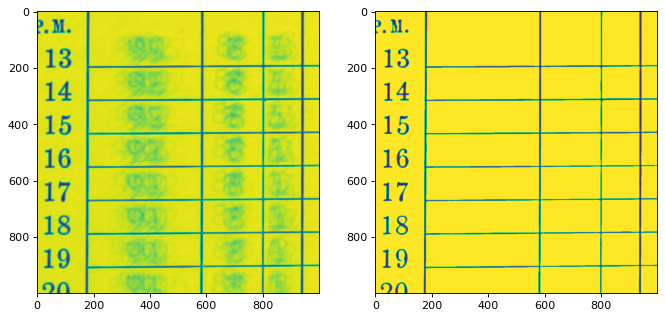

In [21]:
fig = plt.figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(121)
ax.imshow(template[7400:8400,1000:2000])

ax2 = fig.add_subplot(122)
template2 = deepcopy(template[7400:8400,1000:2000])
template2[template2 > 150] = 255
ax2.imshow(template2)
plt.show()

In [8]:
binary_threshold = deepcopy(template)
binary_threshold[binary_threshold > 160] = 255

# Image Thresholding

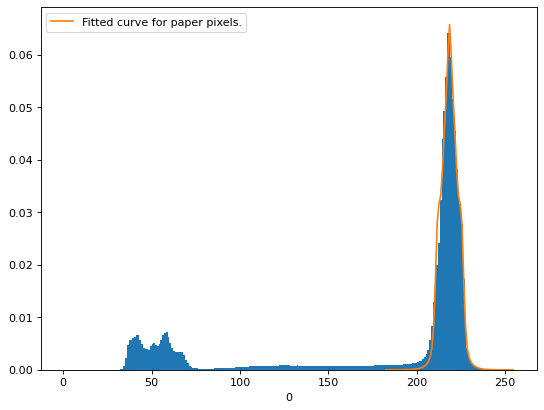

In [41]:
image = cv2.imread("/home/ggdhines/bear/Bear-AG-29-1940-01-5-aligned.png",0)

fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
a,b,_ = ax.hist(image.ravel(),bins=range(0,256,1),density=True)

argmax = np.argmax(a)
highest_point = np.max(a)

df = pd.DataFrame([b[:-1],a]).transpose()
df = df.loc[argmax:].reset_index(drop=True)


df = df.reset_index()
df["mirror"] = 218 - df["index"]

df2 = df.loc[1:,[1,"mirror"]].rename(columns={"mirror":0}).sort_values(0)

df3 = pd.concat([df2,df],ignore_index=True)
df3[0] = df3[0] + 0.5
df3.plot(x=0,y=1,ax=ax)
ax.legend(["Fitted curve for paper pixels."])
plt.show()

Three components

- On the left handside (roughly < 80) are the dark pixels on the outside of the image which frame the page.
- On the right handside (roughly > 200) are the bright pixels which make up the paper in the image.
- All pixels in between are ink pixels.

The fitted curve is based on the RHS, i.e. the LHS is the mirror image. For values close to 218, this fit works really well, i.e. the distribution is symmetric. However, the fit does not work well for lower values. For example, we see more pixels with a value of 200 than expected. This indicates that some of the ink pixels are indistinguishable from paper pixels and any boundary between the two is somewhat abitrary. 

Also not sure whether false positive or false negatives matter more. So for now, going to use a threshold of 200, realizing that it is slightly arbitrary and I might have to come back to it later.

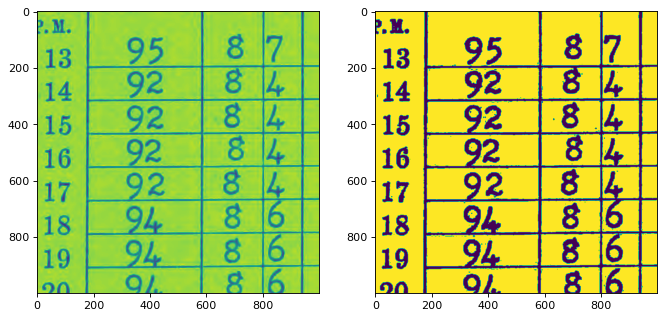

In [40]:
binary_image = deepcopy(image)
m = binary_image <= 200
binary_image[m] = 0
binary_image[~m] = 255

fig = plt.figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(121)
ax.imshow(image[7400:8400,1000:2000])
ax = fig.add_subplot(122)
ax.imshow(binary_image[7400:8400,1000:2000])
plt.show()

Looks really good! (Although not perfect.)

# Template Removal / Cleanup

In [14]:
def remove_template(image,template,background_threshold,template_threshold):
    image = deepcopy(image)
    
    m1 = image > background_threshold
    image[m1] = 255
    
    m2 = template <= template_threshold
    image[m2] = 255
    
    return image

def outline_removal(image):
    kernel = np.ones((5,1),np.uint8)

    eroded = cv2.dilate(image,kernel,iterations = 1)

    kernel = np.ones((1,5),np.uint8)
    eroded = cv2.dilate(eroded,kernel,iterations = 1)
    
    return eroded

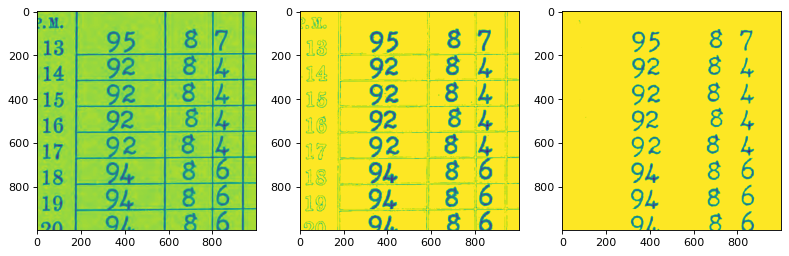

In [17]:
for fname in os.listdir(directory):
    match = re.search("(.*)-(\d+)-(\d+)\-(\d*)-aligned.png",fname)
    if match is None:
        continue
        
    image = cv2.imread(directory+fname,0)
    
    image2 = remove_template(image,template,200,160)
    image3 = outline_removal(image2)
    
    
    fig = plt.figure(num=None, figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(131)
    ax.imshow(image[7400:8400,1000:2000])
    
    ax2 = fig.add_subplot(132)
    ax2.imshow(image2[7400:8400,1000:2000])
    
    ax3 = fig.add_subplot(133)
    ax3.imshow(image3[7400:8400,1000:2000])
    
    plt.show()
    break

# Clean Image and Run OCR

In [24]:
i = 0

for fname in os.listdir(directory):
    match = re.search("(.*)-(\d+)-(\d+)\-(\d*)-aligned.png",fname)
    if match is None:
        continue
        
    print(i,end="\r")
    i += 1
    
    ship,year,month,page = match.groups()
    
    image = cv2.imread(directory+fname,0)
    
    image2 = remove_template(image,template,200,160)
    image3 = outline_removal(image2)
    
    output_file = f"{directory}{ship}-{year}-{month}-{page}"
    
    cv2.imwrite(f"{output_file}_ocr_ready.png",image3)
    cmd = "/home/ggdhines/PycharmProjects/NeuralOCR/neuralOCR/tesseract_boundingboxes"

    command = f"{cmd} eng {output_file}_ocr_ready.png > {output_file}_ocr.csv"
    r = os.system(command)
    
    if r != 0:
        print(command)
        assert False